## Importing the data and the required libraries

In [2]:
#Importing all the libraries and modules
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import joblib

In [3]:
humidity=pd.read_csv(r'../Final Datasets/nHumidity.csv')

In [4]:
print(humidity.shape)
print(humidity.describe())
print(humidity.head())
print(humidity.columns)

(100990, 9)
                Date          Month           Hour          dewpt  \
count  100990.000000  100990.000000  100990.000000  100369.000000   
mean       15.690049       6.579344      10.928844      15.741205   
std         8.769718       3.475841       6.854328       7.058587   
min         1.000000       1.000000       0.000000     -24.000000   
25%         8.000000       4.000000       5.000000      10.000000   
50%        16.000000       7.000000      11.000000      15.000000   
75%        23.000000      10.000000      17.000000      22.000000   
max        31.000000      12.000000      23.000000      75.000000   

          heatindex       humidity           temp           rain  \
count  29155.000000  100233.000000  100317.000000  100990.000000   
mean      35.651710      57.909571      25.451269       0.026260   
std        5.015384      23.807671       8.482859       0.159908   
min       26.800000       4.000000       1.000000       0.000000   
25%       31.700000      3

# Preprocessing the data

### Temperature

In [5]:
# Temperature
print(humidity["temp"].isnull().any())

def replace(j):
    if humidity["temp"][j]!=(-10):
        return humidity["temp"][j]
    else:
        return replace(j+1)
        
humidity["temp"].fillna(-10, inplace = True)

for i in range(100990):
    if humidity["temp"][i]==-10:
        humidity["temp"][i]=(replace(i+1)+humidity["temp"][i-1])/2
    elif humidity["temp"][i]>=50:
        humidity["temp"][i]=(humidity["temp"][i-1]+humidity["temp"][i+1])/2
        

True


In [6]:
print(humidity["temp"].isnull().any())
humidity["temp"][124]

False


15.5

### Humidity

In [7]:
# Humidity Previous

print(humidity["humidity previous"].isnull().any())

humidity["humidity previous"].fillna(-100, inplace = True)

def replace(j):
    if humidity["humidity previous"][j]!=(-100):
        return humidity["humidity previous"][j]
    else:
        return replace(j+1)

for i in range(100990):
    if humidity["humidity previous"][i]==-100:
        humidity["humidity previous"][i]=(replace(i+1)+humidity["humidity previous"][i-1])/2
    elif humidity["humidity previous"][i]>100:
        humidity["humidity previous"][i]=(humidity["humidity previous"][i-1]+humidity["humidity previous"][i+1])/2

True


In [8]:
humidity["humidity previous"][124]

59.0

In [9]:
# Humidity

print(humidity["humidity"].isnull().any())

humidity["humidity"].fillna(-300, inplace = True)

for i in range(100990):
    if humidity["humidity"][i]==-300:
        humidity["humidity"][i]=humidity["humidity previous"][i+1]
    elif humidity["humidity"][i]>100:
        humidity["humidity"][i]=humidity["humidity previous"][i+1]


True


In [10]:
humidity["humidity"][123]

59.0

### Heat Index

In [18]:
#Heat Index

#This is the function for calculating heat index
def HI(t,H):
    c1 = -42.379
    c2= 2.04901523
    c3 = 10.14333127
    c4 = -0.22475541
    c5 = -6.83783 *(0.001)
    c6 = -5.481717 * (0.01)
    c7 = 1.22874 * (0.001)
    c8 = 8.5282 * (0.0001)
    c9 = -1.99 * (0.000001)
    T=(1.8*t)+32
    HI=c1+(c2*T)+(c3*H)+(c4*T*H)+(c5*T*T)+(c6*H*H)+(c7*T*H*T)+(c8*T*H*H)+(c9*T*H*T*H)
    FHI=((HI-32)*5)/9
    return FHI

humidity["heatindex"].fillna(-200, inplace = True)


for i in range(100990):
    if humidity["heatindex"][i]==-200:
        humidity["heatindex"][i]=HI(humidity["temp"][i],humidity["humidity previous"][i])
    elif humidity["heatindex"][i]>60:
        humidity["heatindex"][i]=HI(humidity["temp"][i],humidity["humidity previous"][i])

In [19]:
humidity["heatindex"][124]

27.90896452244449

### Dew Point

In [22]:
# Dew Point

#Function for calculating Dew Point
import math
def ln(n):
    return math.log(n,math.e)
def Tdew(T,H):
    nl =ln(H/100)
    s=237.3+T
    m=17.27*T
    TD = (237.3*(nl+(m/s)))/(17.27+(-1)*(nl+(m/s)))    
    return TD

humidity["dewpt"].fillna(-500, inplace = True)


for i in range(100990):
    if humidity["dewpt"][i]==-500:
        humidity["dewpt"][i]=Tdew(humidity["temp"][i],humidity["humidity previous"][i])
    elif humidity["dewpt"][i]>40 or humidity["dewpt"][i]<(-12):
        humidity["dewpt"][i]=Tdew(humidity["temp"][i],humidity["humidity previous"][i])
        

In [23]:
humidity["dewpt"][124]

7.531332110544606

In [24]:
humidity_num=humidity[list(humidity.dtypes[humidity.dtypes!='object'].index)]
humidity_y=humidity_num.pop('humidity')
humidity_x=humidity_num

## Training ML Models for Predicting Humidity

In [25]:
train_x,test_x,train_y,test_y=train_test_split(humidity_x,humidity_y,test_size=0.2,random_state=4)
train_x.head()

,Date,Month,Hour,dewpt,heatindex,temp,rain,humidity previous
99686,6,1,15,17.0,15.316544,18.0,0,96.0
18305,29,1,10,5.0,24.825667,21.0,0,35.0
91877,20,8,6,25.0,36.195542,32.0,0,57.0
55714,29,2,14,12.0,25.389065,24.0,0,47.0
40664,2,2,7,13.0,21.773657,16.0,0,82.0


### Linear Regression

In [26]:
hmodel = LinearRegression()
hmodel.fit(train_x,train_y)

LinearRegression()

In [28]:
print(test_x)
prediction=hmodel.predict(test_x)
#Calculating error
np.mean((prediction-test_y)**2)

       Date  Month  Hour  dewpt  heatindex  temp  rain  humidity previous
16733    18     11     8    4.0  26.768215  28.0     0               21.0
82934    21      4    15   14.0  28.553710  30.0     0               27.0
33831    11      4    13    3.0  32.450585  35.0     0               13.0
22660    14     12    19   10.0  25.969198  14.0     0               77.0
47063    16      8    14   26.0  33.600000  28.0     0               89.0
...     ...    ...   ...    ...        ...   ...   ...                ...
26343    24      5     8   16.0  44.400000  43.0     0               21.0
10264    12      9    22   24.0  25.540468  25.0     0               94.0
17753     4      1    15    9.0  26.601143  11.0     0               88.0
98956     2     12    12   17.0  23.190211  22.0     0               73.0
46164    26      7    23   25.0  34.500000  29.0     0               79.0

[20198 rows x 8 columns]


101.04667661277232

In [29]:
pd.DataFrame({'actual':test_y,'prediction':prediction,'diff':(test_y-prediction)})

,actual,prediction,diff
16733,20.0,22.335772,-2.335772
82934,40.0,34.963251,5.036749
33831,18.0,15.554636,2.445364
22660,77.0,79.360381,-2.360381
47063,94.0,86.176391,7.823609
...,...,...,...
26343,21.0,21.356693,-0.356693
10264,100.0,94.990357,5.009643
17753,94.0,85.210003,8.789997
98956,83.0,71.625814,11.374186


In [44]:
# Save the model as a pickle in a file 
joblib.dump(hmodel, '../Trained Models/HLinearRegression.pkl') 
  
# Load the model from the file only to be uncommented when to be used 
#LR = joblib.load('LRTP.pkl')  
  
# Use the loaded model to make predictions 
#LR.predict(X_test)

['../Trained Models/HLinearRegression.pkl']

### Polynomial Regression

In [31]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

In [36]:
poly=PolynomialFeatures(degree=4, include_bias=False)
x_poly=poly.fit_transform(train_x)
lin2=LinearRegression()
lin2.fit(x_poly,train_y)

LinearRegression()

In [37]:
prediction2=lin2.predict(poly.fit_transform(test_x))
#Calculating the error
np.mean((prediction2-test_y)**2)

65.75691081269004

In [31]:
pd.DataFrame({'actual':test_y,'prediction':prediction2,'diff':(test_y-prediction2)})

,actual,prediction,diff
16733,20.0,23.662040,-3.662040
82934,40.0,40.128327,-0.128327
33831,18.0,14.604543,3.395457
22660,77.0,79.144212,-2.144212
47063,94.0,91.989363,2.010637
...,...,...,...
26343,21.0,20.622246,0.377754
10264,100.0,93.507875,6.492125
17753,94.0,91.782633,2.217367
98956,83.0,77.062356,5.937644


In [43]:
#Saving the Polynomial Regression Model
joblib.dump(lin2, '../Trained Models/HPolynomialRegression.pkl') 
  
# Load the model from the file only to be uncommented when to be used 
#PR = joblib.load('HUMPR.pkl')  
  
# Use the loaded model to make predictions 
#PR.predict(X_test)

['../Trained Models/HPolynomialRegression.pkl']

### Decision Tree

In [39]:
#Decision Tree Model
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(train_x,train_y)

DecisionTreeRegressor(random_state=0)

In [40]:
prediction3=regressor.predict(test_x)
print(np.mean((prediction3-test_y)**2))
dt=np.array([6,7,17,26,43,33,1,65]).reshape(1,-1)
print(regressor.predict(dt))

111.34274911363609
[75.]


In [41]:
test_x.shape

(20198, 8)

In [42]:
test_x.head(3)

,Date,Month,Hour,dewpt,heatindex,temp,rain,humidity previous
16733,18,11,8,4.0,26.768215,28.0,0,21.0
82934,21,4,15,14.0,28.553710,30.0,0,27.0
33831,11,4,13,3.0,32.450585,35.0,0,13.0


In [45]:
#Saving the Decision Tree
joblib.dump(regressor, '../Trained Models/HDecisionTree.pkl') 
  
# Load the model from the file only to be uncommented when to be used 
#DT = joblib.load('HUMDT.pkl')  
  
# Use the loaded model to make predictions 
#DT.predict(X_test)

['../Trained Models/HDecisionTree.pkl']

### Random Forest

In [46]:
#Random Forest Model
from sklearn.ensemble import RandomForestRegressor
regr=RandomForestRegressor(max_depth=60,random_state=0,n_estimators=100)
regr.fit(train_x,train_y)

RandomForestRegressor(max_depth=60, random_state=0)

In [47]:
prediction4=regr.predict(test_x)
np.mean((prediction4-test_y)**2)

65.45507212402073

In [48]:
regr.predict(dt)

array([65.88])

In [49]:
pd.DataFrame({'actual':test_y,'prediction':prediction4,'diff':(test_y-prediction4)})

,actual,prediction,diff
16733,20.0,19.850000,0.150000
82934,40.0,34.710000,5.290000
33831,18.0,15.370000,2.630000
22660,77.0,84.280000,-7.280000
47063,94.0,90.030000,3.970000
...,...,...,...
26343,21.0,19.189333,1.810667
10264,100.0,91.280000,8.720000
17753,94.0,90.067000,3.933000
98956,83.0,79.510000,3.490000


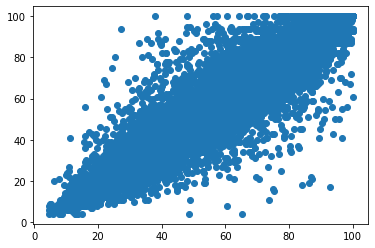

In [50]:
plt.scatter(prediction4,test_y)

In [51]:
# Save the model as a pickle in a file 
joblib.dump(regr,'../Trained Models/HRandomForest.pkl') 
  
# Load the model from the file only to be uncommented when to be used 
#RF = joblib.load('HUMRF.pkl')  
  
# Use the loaded model to make predictions 
#RF.predict(X_test)

['../Trained Models/HRandomForest.pkl']

In [52]:
humidity.isnull().any()

Date                 False
Month                False
Hour                 False
dewpt                False
heatindex            False
humidity             False
temp                 False
rain                 False
humidity previous    False
dtype: bool